<h1 align="center"> Image Captioning </h1>

In this notebook you will teach a network to do image captioning
![img](https://cdn-images-1.medium.com/max/716/1*vzFwXFJOrg6WRGNsYYT6qg.png)
_image [source](https://towardsdatascience.com/image-captioning-in-deep-learning-9cd23fb4d8d2)_



#### Alright, here's our plan:
1. Take a pre-trained inception v3 to vectorize images
2. Stack an LSTM on top of it
3. Train the thing on [MSCOCO](http://cocodataset.org/#download)

In [1]:
# Please eithrer download data from https://yadi.sk/d/b4nAwIE73TVcp5 or generate it manually with preprocess_data.

In [2]:
!rm -rf *
!sudo apt install -q cadaver

Reading package lists...
Building dependency tree...
Reading state information...
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  libneon27-gnutls
The following NEW packages will be installed:
  cadaver libneon27-gnutls
0 upgraded, 2 newly installed, 0 to remove and 37 not upgraded.
Need to get 135 kB of archives.
After this operation, 492 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libneon27-gnutls amd64 0.30.2-3~ubuntu18.04.1 [66.5 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 cadaver amd64 0.23.3-2ubuntu3 [68.1 kB]
Fetched 135 kB in 0s (1,870 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 2.)

In [3]:
!cadaver https://webdav.yandex.ru

Authentication required for Yandex.Disk on server `webdav.yandex.ru':
Username: garakhan.talibov
Password: dav:/> ls
Listing collection `/': succeeded.
Coll:   Загрузки                       0  Oct 30 15:06
Coll:   Pictures                               0  Oct 31 11:17
        Горы.jpg                     1762478  Oct 30 14:50
        Зима.jpg                     1394575  Oct 30 14:50
        Мишки.jpg                   1555830  Oct 30 14:50
        Море.jpg                     1080301  Oct 30 14:50
        Москва.jpg                 1454228  Oct 30 14:50
        Санкт-Петербург.jpg    2573704  Oct 30 14:50
        Хлебные крошки.mp4   31000079  Oct 30 14:50
        Pictures.zip                     2829810  Oct 31 11:22
dav:/> ls
Listing collection `/': succeeded.
Coll:   Загрузки                       0  Oct 30 15:06
Coll:   Pictures                               0  Oct 31 11:17
        Горы.jpg                     1762478  Oct 30 14:50
        Зима.jpg                     1394575  Oc

In [4]:
!tar -xvf handout.tar.gz

data/
data/captions_tokenized.json
data/image_codes.npy


### Data preprocessing

In [5]:
%%time
# Read Dataset
import numpy as np
import json

img_codes = np.load("data/image_codes.npy")
captions = json.load(open('data/captions_tokenized.json'))

CPU times: user 222 ms, sys: 485 ms, total: 708 ms
Wall time: 705 ms


### Data structure

To save your time, we've already vectorized all MSCOCO17 images with a pre-trained inception_v3 network from [torchvision](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py).

The whole process takes anywhere between a day on CPU and 10min on 3x tesla m40. If you want to play with that yourself, [you're welcome](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).

In [6]:
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


As you can see, all captions are already tokenized and lowercased. We now want to split them and add some special tokens for start/end of caption.

In [7]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]


You don't want your network to predict a million-size vector of probabilities at each step, so we're gotta make some cuts. 

We want you to __count the occurences of each word__ so that we can decide which words to keep in our vocabulary.

In [8]:
# Build a Vocabulary
from collections import Counter
word_counts = Counter()

#Compute word frequencies for each word in captions. See code above for data structure
# <YOUR CODE HERE>
words=[]
for i in captions:
  for j in i:
    words.extend(j)
word_counts=Counter(words)

In [9]:
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [10]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i, seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [11]:
#try it out on several descriptions of a random image
rand_idx=np.random.randint(0, len(captions))
print ("Image: ", rand_idx, "\n")
as_matrix(captions[np.random.randint(0, len(captions))])

Image:  5800 



array([[   1,   24,  288,   71,  300,   58,   24,   47,  291,  663,    6,
         182,   12,    2,    3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  291,   14,  437,   15,  427,  123,   24, 1384,  867,
          14, 1554,   15, 1007,  324,   35,   24,   71,   12,    2,    3],
       [   1,   24,   71,   63,  136,   24,  291,   14,  182,  123,   24,
        1005,   14, 1007,  123,   15,   24, 1379,   14, 1554,   12,    2],
       [   1,   24, 2088,   71,   35,  480,   24, 1005,  123,   24, 1007,
         699,  123,  867,   14, 1554,   15,  935,   41,  755,   12,    2],
       [   1,   24,   47,  985,  291,   58,  182,   24,  699,   24, 1005,
          15,  210, 1554,    2,    3,    3,    3,    3,    3,    3,    3]],
      dtype=int32)

### Building our neural network

As we mentioned earlier, we shall build an rnn "language-model" conditioned on vectors from the convolutional part. 

![img](https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png)
_image: http://bit.ly/2FKnqHm_


We'll unbox the inception net later to save memory, for now just pretend that it's available.


In [12]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [13]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048):
        """ A recurrent 'head' network for image captioning. See scheme above. """
        super(self.__class__, self).__init__()
        
        # a layer that converts conv features to 
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)
        
        # recurrent part, please create the layers as per scheme above.

        # create embedding for input words. Use the parameters (e.g. emb_size).
        # self.emb = <YOUR CODE> 
        self.emb=nn.Embedding(n_tokens, emb_size)
            
        # lstm: create a recurrent core of your network. Use either LSTMCell or just LSTM. 
        # In the latter case (nn.LSTM), make sure batch_first=True
        # self.lstm = <YOUR CODE>
        self.lstm=nn.LSTMCell(emb_size, lstm_units, bias=False)
            
        # create logits: linear layer that takes lstm hidden state as input and computes one number per token
        # self.logits = <YOUR CODE>
        self.logits=nn.LazyLinear(n_tokens)
        
    def forward(self, image_vectors, captions_ix):
        """ 
        Apply the network in training mode. 
        :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
        :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """
        initial_cell = self.cnn_to_c0(image_vectors)
        initial_hid = self.cnn_to_h0(image_vectors)
        
        # compute embeddings for captions_ix
        # captions_emb = <YOUR CODE>
        captions_emb = self.emb(captions_ix).permute(1, 0, 2)
        # print (captions_emb.shape)
        # print (initial_cell.shape)
        # print (initial_hid.shape)
        
        # apply recurrent layer to captions_emb. 
        # 1. initialize lstm state with initial_* from above
        # 2. feed it with captions. Mind the dimension order in docstring
        # 3. compute logits for next token probabilities
        # Note: if you used nn.LSTM, you can just give it (initial_cell[None], initial_hid[None]) as second arg

        # lstm_out should be lstm hidden state sequence of shape [batch, caption_length, lstm_units]
        # lstm_out = <YOUR_CODE>
        hid=[]
        for i in range (captions_emb.shape[0]):
          initial_hid, initial_cell = self.lstm(captions_emb[i], (initial_hid, initial_cell))
          hid.append(initial_hid)
        
        hid=torch.stack(hid, dim=0)
        # compute logits from lstm_out
        # logits = <YOUR_CODE>
        logits=self.logits(hid).permute(1, 0, 2)
        # print (logits.shape)
        
        return logits

In [14]:
def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
        padded with pad_ix
    :returns: crossentropy (neg llh) loss for next captions_ix given previous ones. Scalar float tensor
    """
    
    # captions for input - all except last cuz we don't know next token for last one.
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()
    
    # apply the network, get predictions for captions_ix_next
    logits_for_next = network.forward(image_vectors, captions_ix_inp)

    # print (logits_for_next.shape)
    # print (captions_ix_next.shape)

    # print ("\n\n")

    # print (logits_for_next.contiguous().view(-1, n_tokens).shape)
    # print (captions_ix_next.contiguous().view(-1).shape)
    
    
    # compute the loss function between logits_for_next and captions_ix_next
    # Use the mask, Luke: make sure that predicting next tokens after EOS do not contribute to loss
    # you can do that either by multiplying elementwise loss by (captions_ix_next != pad_ix)
    # or by using ignore_index in some losses.
    
    # loss = <YOUR CODE>
    next_logp=F.log_softmax(logits_for_next, -1)
    loss = F.nll_loss(next_logp.contiguous().view(-1, n_tokens), 
                  captions_ix_next.contiguous().view(-1))

    
    return loss

In [15]:
network = CaptionNet(n_tokens)

dummy_img_vec = torch.randn(len(captions[0]), 2048)
dummy_capt_ix = torch.tensor(as_matrix(captions[0]), dtype=torch.int64)

dummy_logits = network.forward(dummy_img_vec, dummy_capt_ix)

print('shape:', dummy_logits.shape)
assert dummy_logits.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], n_tokens)

dummy_loss = compute_loss(network, dummy_img_vec, dummy_capt_ix)

assert len(dummy_loss.shape) <= 1, 'loss must be scalar'
assert dummy_loss.data.numpy() > 0, "did you forget the 'negative' part of negative log-likelihood"
print (dummy_loss)

dummy_loss.backward()

assert all(param.grad is not None for param in network.parameters()), \
        'loss should depend differentiably on all neural network weights'

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


shape: torch.Size([5, 16, 10403])
tensor(9.2244, grad_fn=<NllLossBackward>)


Create ~~adam~~ your favorite optimizer for the network.

# Training

* First implement the batch generator
* Than train the network as usual

In [16]:
dev='cuda'

In [17]:
from sklearn.model_selection import train_test_split
captions = np.array(captions)
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(img_codes, captions,
                                                                                test_size=0.1,
                                                                                random_state=42)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [18]:
from random import choice

def generate_batch(img_codes, captions, batch_size, max_caption_len=None):
    
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)
    
    #get images
    batch_images = img_codes[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick one from a set of captions for each image
    batch_captions = list(map(choice,captions_for_batch_images))
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return torch.tensor(batch_images, dtype=torch.float32).to(dev), torch.tensor(batch_captions_ix, dtype=torch.int64).to(dev)
    

In [19]:
generate_batch(img_codes,captions,3)

(tensor([[0.1694, 0.4054, 0.0568,  ..., 0.0087, 0.4142, 0.2536],
         [0.3354, 0.2438, 0.3269,  ..., 0.2629, 0.5321, 0.5109],
         [0.1476, 0.3436, 0.2832,  ..., 0.1823, 0.8688, 0.2198]],
        device='cuda:0'),
 tensor([[   1,   24,  262,   78,   35,   45,  382,   14,   24,   47,  386,   12,
             2,    3,    3,    3],
         [   1,   24,  195, 1728, 1912, 4642,  357,  140,   35,   45,  331,   14,
            24,  103,   12,    2],
         [   1,   24,  372,  310, 3290,  163,   24,  876,   35,   45,  103,   12,
             2,    3,    3,    3]], device='cuda:0'))

### Main loop

Train on minibatches just as usual. Evaluate on val from time to time.

##### TIps
* If training loss has become close to 0 or model produces garbage,
    double-check that you're predicting __next__ words, not current or t+2'th words.
* If the model generates fluent captions that have nothing to do with the images
 * this may be due to recurrent net not receiving image vectors.
 * alternatively it may be caused by gradient explosion, try clipping 'em or just restarting the training
 * finally, you may just need to train the model a bit more


* Crossentropy is a poor measure of overfitting
 * Model can overfit validation crossentropy but keep improving validation quality.
 * Use human _(manual)_ evaluation or try automated metrics: [cider](https://github.com/vrama91/cider) or [bleu](https://www.nltk.org/_modules/nltk/translate/bleu_score.html)
 

* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again
 
* The typical loss values should be around 3~5 if you average over time, scale by length if you sum over time. The reasonable captions began appearing at loss=2.8 ~ 3.0
 

In [40]:
network = CaptionNet(n_tokens).to(dev)

# <YOUR CODE>
optimizer=torch.optim.Adam(params=network.parameters(), lr=0.001)

batch_size = 200  # adjust me
n_epochs = 100  # adjust me
n_batches_per_epoch = 50  # adjust me
n_validation_batches = 10  # how many batches are used for validation after each epoch

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


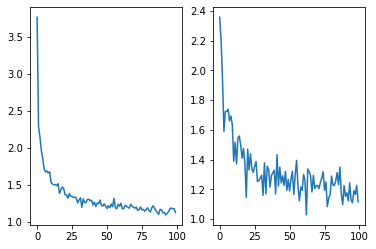


Epoch: 99, train loss: 1.124184206724167, val loss: 1.116412764787674
Finished!


In [41]:
from tqdm import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

TL=[]
VL=[]
for epoch in range(n_epochs):
    
    train_loss=0
    network.train(True)
    for _ in tqdm(range(n_batches_per_epoch)):
        
        loss_t = compute_loss(network, *generate_batch(train_img_codes, train_captions, batch_size))
        
        
        # clear old gradients; do a backward pass to get new gradients; then train with opt
        # <YOUR CODE>
        
        train_loss += loss_t.cpu().detach().numpy()

        loss_t.backward()
        nn.utils.clip_grad_norm_(network.parameters(), max_norm=1)
        optimizer.step()
        optimizer.zero_grad()
        
    train_loss /= n_batches_per_epoch
    TL.append(train_loss)
    
    val_loss=0
    network.train(False)
    for _ in range(n_validation_batches):
        loss_t = compute_loss(network, *generate_batch(val_img_codes, val_captions, batch_size))
        val_loss += loss_t.cpu().detach().numpy()
    val_loss /= n_validation_batches
    VL.append(val_loss)

    clear_output(True)
    
    fig, ax=plt.subplots(1, 2)
    ax[0].plot (range(len(TL)), TL)
    
    ax[1].plot(range(len(VL)), VL)
    plt.show()

    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finished!")

In [27]:
torch.cuda.get_device_name(torch.cuda.current_device())

'Tesla K80'

### Apply trained model

Let's unpack our pre-trained inception network and see what our model is capable of.

In [28]:
!wget -O beheaded_inception3.py https://github.com/yandexdataschool/Practical_DL/blob/fall21/week06_rnn/beheaded_inception3.py?raw=true

--2021-10-31 15:35:57--  https://github.com/yandexdataschool/Practical_DL/blob/fall21/week06_rnn/beheaded_inception3.py?raw=true
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/yandexdataschool/Practical_DL/raw/fall21/week06_rnn/beheaded_inception3.py [following]
--2021-10-31 15:35:57--  https://github.com/yandexdataschool/Practical_DL/raw/fall21/week06_rnn/beheaded_inception3.py
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall21/week06_rnn/beheaded_inception3.py [following]
--2021-10-31 15:35:58--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall21/week06_rnn/beheaded_inception3.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110

In [29]:
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False).to(dev)

/usr/local/lib/python3.7/dist-packages/torchvision/models/inception.py:82: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)
Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

### Generate caption

The function below creates captions by sampling from probabilities defined by the net.

The implementation used here is simple but inefficient (quadratic in lstm steps). We keep it that way since it isn't a performance bottleneck.

In [30]:
def generate_caption(image, caption_prefix = ("#START#",), 
                     t=1, sample=True, max_len=100):
    
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32).to(dev)
    
    vectors_8x8, vectors_neck, logits = inception(image[None])
    caption_prefix = list(caption_prefix)
    
    for _ in range(max_len):
        
        prefix_ix = as_matrix([caption_prefix])
        prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64).to(dev)
        next_word_logits = network.forward(vectors_neck, prefix_ix)[0, -1]
        next_word_probs = F.softmax(next_word_logits, -1).cpu().detach().numpy()
        
        
        assert len(next_word_probs.shape) ==1, 'probs must be one-dimensional'
        next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

        if sample:
            next_word = np.random.choice(vocab, p=next_word_probs) 
        else:
            next_word = vocab[np.argmax(next_word_probs)]

        caption_prefix.append(next_word)

        if next_word=="#END#":
            break
            
    return caption_prefix

In [42]:
from matplotlib import pyplot as plt
# from scipy.misc import imresize
import cv2 as cv
%matplotlib inline

#sample image
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = cv.resize(img, (299, 299)).astype('float32') / 255.

--2021-10-31 15:54:16--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 199.232.192.70, 199.232.196.70
Connecting to pixel.nymag.com (pixel.nymag.com)|199.232.192.70|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg [following]
--2021-10-31 15:54:16--  https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg
Resolving pyxis.nymag.com (pyxis.nymag.com)... 151.101.2.217, 151.101.66.217, 151.101.130.217, ...
Connecting to pyxis.nymag.com (pyxis.nymag.com)|151.101.2.217|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54731 (53K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>]  53.45K  --.-KB/s    in 0.004s  

2021-10-31 15:54:16 (12.0 MB/s) - ‘data/img.jpg’ sa

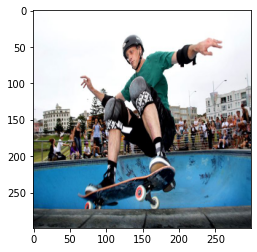

In [43]:
plt.imshow(img)

In [44]:
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

a man riding a skateboard down a rail .
a man riding a skateboard down a rail .
a man riding a skateboard down a ramp .
a man riding a skateboard down a street .
a man riding a skateboard down a ramp .
a man riding a skateboard down a rail .
a man riding a skateboard down a ramp .
a man riding a skateboard down a rail .
a man riding a skateboard down a rail .
a skateboarder is doing tricks on a rail .


--2021-10-31 15:54:27--  http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Resolving ccanimalclinic.com (ccanimalclinic.com)... 162.159.135.42
Connecting to ccanimalclinic.com (ccanimalclinic.com)|162.159.135.42|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg [following]
--2021-10-31 15:54:27--  https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Connecting to ccanimalclinic.com (ccanimalclinic.com)|162.159.135.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106870 (104K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 104.37K   249KB/s    in 0.4s    

2021-10-31 15:54:28 (249 KB/s) - ‘data/img.jpg’ saved [106870/106870]



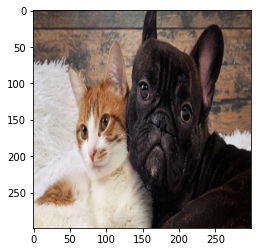

a cat is sitting on a chair next to a chair .
a cat is sitting on a chair next to a chair .
a cat with a backpack and a black hat .
a cat is sitting on a chair next to a chair .
a cat is sitting on a chair with a cat .
a cat is sitting on a chair next to a chair .
a cat is sitting on a chair next to a chair .
a cat is sitting on a chair next to a laptop .
a cat is sitting on a chair next to a chair .
a cat is sitting on a chair next to a chair .


In [45]:
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = cv.resize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

# Demo
### Find at least 10 images to test it on.
* Seriously, that's part of an assignment. Go get at least 10 pictures to get captioned
* Make sure it works okay on __simple__ images before going to something more comples
* Photos, not animation/3d/drawings, unless you want to train CNN network on anime
* Mind the aspect ratio

In [35]:
#apply your network on image sample you found
#
#
import os
def capt (src):
  img = plt.imread(src)
  img = cv.resize(img, (299, 299)).astype('float32') / 255.

  plt.imshow(img)
  plt.show()
  
  for i in range(10):
      print(' '.join(generate_caption(img, t=5.)[1:-1]))

In [36]:
# garakhan.talibov
# xjxirpmohrlulvea
# get Pictures.zip

In [102]:
!cadaver https://webdav.yandex.ru

Authentication required for Yandex.Disk on server `webdav.yandex.ru':
Username: garakhan.talibov
Password: dav:/> get Pictures.zip
Progress: [=============================>] 100.0% of 3767058 bytes succeeded.
dav:/> ls
Listing collection `/': succeeded.
Coll:   Загрузки                       0  Oct 30 15:06
Coll:   Pictures                               0  Oct 31 11:17
        Горы.jpg                     1762478  Oct 30 14:50
        Зима.jpg                     1394575  Oct 30 14:50
        Мишки.jpg                   1555830  Oct 30 14:50
        Море.jpg                     1080301  Oct 30 14:50
        Москва.jpg                 1454228  Oct 30 14:50
        Санкт-Петербург.jpg    2573704  Oct 30 14:50
        Хлебные крошки.mp4   31000079  Oct 30 14:50
        Pictures.zip                     3767058  Oct 31 16:47
dav:/> 
dav:/> get Мишки.jpg
Progress: [=============================>] 100.0% of 1555830 bytes succeeded.
dav:/> quit
Connection to `webdav.yandex.ru' closed.


In [103]:
!unzip -q Pictures.zip
!rm Pictures.zip

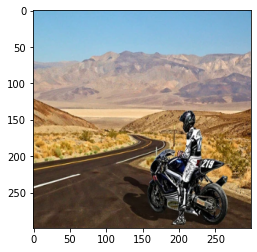

a motorcycle parked on the side of a road .
a motorcycle parked on a dirt road next to a river .
a motorcycle parked on a dirt road next to a forest .
a motorcycle parked on the side of a road .
a motorcycle parked on a dirt road next to a forest .
a motorcycle parked on a dirt road next to a road .
a motorcycle parked on a dirt road next to a forest .
a motorcycle parked on a dirt road next to a forest .
a motorcycle parked on the side of a road .
a motorcycle parked on a dirt road next to a forest .


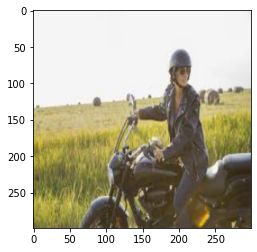

a man riding a motorcycle on a dirt road .
a man is riding a motorcycle with a helmet .
a man riding a motorcycle on a dirt road .
a man riding a motorcycle on a dirt road .
a man is riding a motorcycle on a dirt road .
a man is riding a motorcycle in the middle of a field .
a man riding a motorcycle on a dirt road .
a man is riding a motorcycle on a dirt road .
a man is riding a motorcycle on a dirt road .
a man is riding a motorcycle on a dirt road .


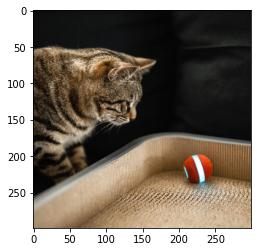

a cat sitting on a chair next to a cat .
a cat sitting on top of a wooden chair .
a cat laying on a chair next to a laptop .
a cat sitting on a chair next to a laptop .
a cat laying on top of a chair next to a laptop .
a cat sitting on a chair next to a laptop .
a cat sitting on top of a chair next to a laptop .
a cat sitting on a chair next to a cat .
a cat sitting on a chair next to a laptop .
a cat sitting on top of a chair next to a car .


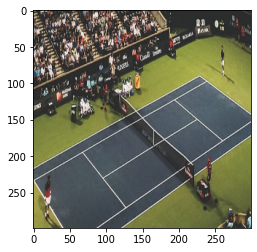

a man is playing tennis on a court .
a man is doing a trick on a tennis court .
a man is playing tennis on a court .
a man standing on a tennis court holding a racquet .
a man is playing tennis on a court .
a man in a white shirt is playing tennis
a man is playing tennis on a court .
a tennis player is hitting a ball with a racket .
a man is playing tennis on a tennis court .
a man is playing tennis on a court .


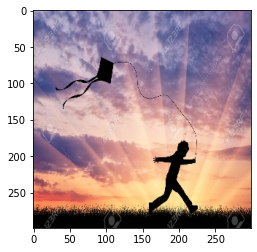

a man flying a kite in the sky .
a man flying a kite in a field .
a man flying a kite in a field .
a man flying a kite in the sky .
a man flying a kite in a field .
a man flying a kite in the sky .
a man flying a kite in the sky .
a man flying a kite in a park .
a man flying a kite in the sky .
a man flying a kite in a park .


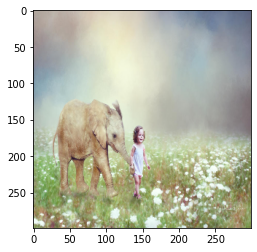

a couple of elephants standing next to each other .
a couple of elephants standing next to each other .
a group of elephants standing in a field .
a couple of elephants standing next to each other .
a couple of elephants standing next to each other .
a large elephant standing in a field with trees in the background .
a group of elephants standing next to each other .
a group of elephants standing in the grass .
a group of elephants walking through a grassy field .
a large elephant standing in a field next to a tree .


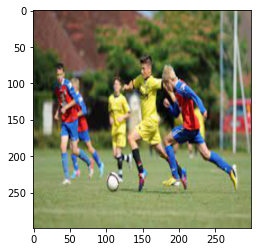

a group of people are playing soccer on a field .
a group of people playing soccer on a field .
a group of young men playing a game of soccer .
a group of people on a field playing soccer .
a group of young men playing a game of frisbee .
a group of young men playing a game of frisbee .
a group of men playing a game of soccer .
a group of people in a field playing soccer .
a group of people in a field playing soccer .
a group of people in a field playing soccer .


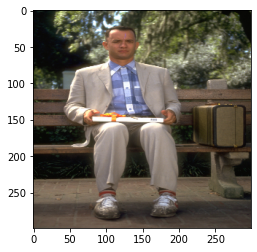

a man is sitting on a bench with a dog .
a man in a suit and tie sitting on a bench .
a man sitting on a bench in front of a fence .
a man in a suit and tie is sitting on a bench .
a man sitting on a bench with a dog in his lap .
a man in a suit and tie sitting on a bench .
a man sitting on a bench in front of a fence .
a man in a suit and tie sitting on a bench .
a man sitting on a bench in front of a building .
a man sitting on a bench with a dog .


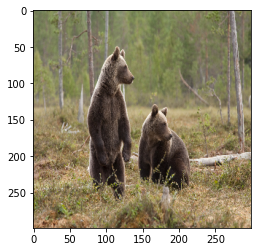

a bear standing in the grass next to a tree .
a bear walking through a forest in a forest .
a bear is standing in the grass .
a bear is standing in the grass .
a bear standing in the grass next to a tree .
a bear is standing in the grass next to a tree .
a bear walking through the grass next to a tree .
a bear is standing in the grass near a fence .
a bear standing in the grass next to a tree .
a bear is standing in the grass near a fence .


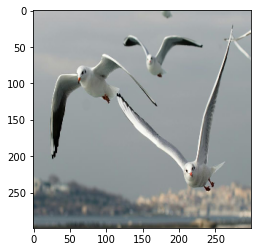

a large bird flying over a body of water .
a man flying a kite in the air .
a person is flying a kite in the air .
a bird flying over a tree in a park .
a large bird flying over a tree .
a bird flying over a body of water .
a bird flying in the air over a body of water .
a bird flying in the air over a body of water .
a bird flying over a body of water .
a person is flying a kite in the air .


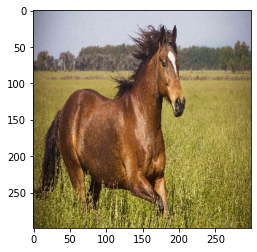

a horse is standing in the grass near a fence .
a horse is standing in the grass .
a horse is standing in the grass .
a horse standing in a field with a dog .
a horse is standing in the grass .
a horse standing in a field with a dog .
a horse is standing in the grass .
a horse is standing in the grass .
a horse is standing in the grass .
a horse is standing in the grass .


In [111]:
for i in os.listdir('Pictures'):
  try:
    capt(f"Pictures/{i}")
  except:
    continue

### Now what?

Your model produces some captions but you still strive to improve it? You're damn right to do so. Here are some ideas that go beyond simply "stacking more layers". The options are listed easiest to hardest.

##### Attention
You can build better and more interpretable captioning model with attention.
* How it works: https://distill.pub/2016/augmented-rnns/
* One way of doing this in captioning: https://arxiv.org/abs/1502.03044
* You will have to create a dataset for attention with [this notebook](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).

##### Subword level captioning
In the base version, we replace all rare words with UNKs which throws away a lot of information and reduces quality. A better way to deal with vocabulary size problem would be to use Byte-Pair Encoding

* BPE implementation you can use: [github_repo](https://github.com/rsennrich/subword-nmt). 
* Theory: https://arxiv.org/abs/1508.07909
* It was originally built for machine translation, but it should work with captioning just as well.

#### Reinforcement learning
* After your model has been pre-trained in a teacher forced way, you can tune for captioning-speific models like CIDEr.
* Tutorial on RL for sequence models: [practical_rl week8](https://github.com/yandexdataschool/Practical_RL/tree/master/week8_scst)
* Theory: https://arxiv.org/abs/1612.00563